##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a stateful RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c07_forecasting_with_stateful_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c07_forecasting_with_stateful_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

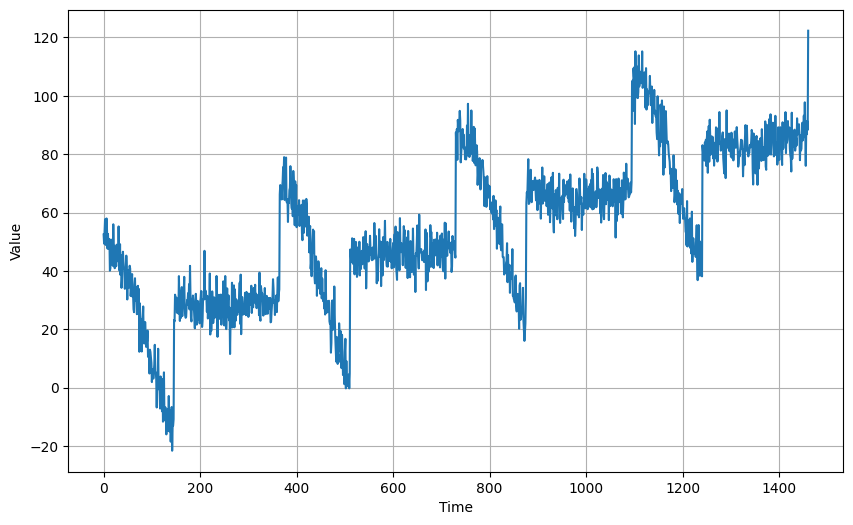

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Stateful RNN Forecasting

In [5]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [6]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [7]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 2s 8ms/step - loss: 35.6293 - mae: 36.1260 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 29.6942 - mae: 30.1893 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 7ms/step - loss: 28.8109 - mae: 29.3063 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 25.9550 - mae: 26.4514 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 23.6258 - mae: 24.1210 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 7ms/step - loss: 21.2065 - mae: 21.6997 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 0s 7ms/step - loss: 19.1192 - mae: 19.6120 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 7ms/step - loss: 17.4864 - mae: 17.9766 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 0s 7ms/step - loss: 16.3385 - mae: 16.8311 

(1e-08, 0.0001, 0.0, 30.0)

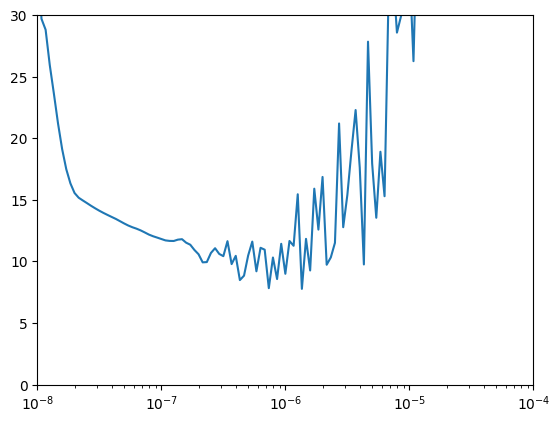

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 2s 22ms/step - loss: 53405.8008 - mae: 53406.3086 - val_loss: 104910.2969 - val_mae: 104910.8281
Epoch 2/500
15/33 [============>.................] - ETA: 0s - loss: 54958.5508 - mae: 54959.0391

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 10ms/step - loss: 44238.7539 - mae: 44239.2461 - val_loss: 116855.5781 - val_mae: 116856.0859
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 49689.2109 - mae: 49689.7109 - val_loss: 55295.8242 - val_mae: 55296.3281
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 61907.6602 - mae: 61908.1602 - val_loss: 100093.0312 - val_mae: 100093.5234
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 39369.1406 - mae: 39369.6523 - val_loss: 58865.2461 - val_mae: 58865.7461
Epoch 6/500
33/33 [==============================] - 0s 10ms/step - loss: 32532.5840 - mae: 32533.0840 - val_loss: 43975.1367 - val_mae: 43975.6367
Epoch 7/500
33/33 [==============================] - 0s 11ms/step - loss: 23653.9062 - mae: 23654.4102 - val_loss: 2444.9751 - val_mae: 2445.4746
Epoch 8/500
33/33 [==============================] - 0s 10ms/step - loss: 30317.8848 - mae: 30318.3887 - val_loss: 94904.16

In [11]:
model = keras.models.load_model("my_checkpoint.h5")

In [12]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 0s 277ms/step


In [13]:
rnn_forecast.shape

(461,)

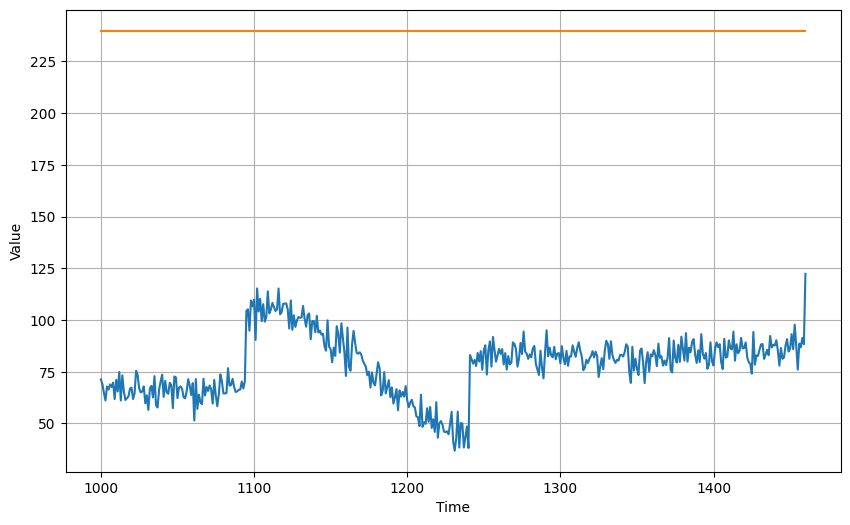

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

161.3576